In [1]:
#import packages
library(readr)
library(tidyverse)
library(dplyr)
library(tidymodels)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ purrr     1.0.2
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::

In [2]:
heart_data <- read_csv('https://raw.githubusercontent.com/ftabuchi/group_21_DSCI100_project/main/data/processed.switzerland.data', col_names=FALSE)
heart_data |> sample_n(6)
heart_data <- heart_data |> select(X1, X3, X4)
heart_data <- heart_data |> rename(age=X1, chest_pain_ctg=X3, blood_pressure_mm_Hg=X4) |> 
                                        filter(blood_pressure_mm_Hg != "?")

heart_data |> sample_n(6)


Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X6, X7, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X5, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
72,1,3,160,0,?,2,114,0,1.6,2,2,?,0
60,1,4,160,0,?,0,149,0,.4,2,?,?,1
58,1,4,170,0,?,1,105,1,0,?,?,3,1
60,1,3,115,0,?,0,143,0,2.4,1,?,?,1
47,1,3,155,0,0,0,118,1,1,2,?,3,3
53,1,2,120,0,0,0,95,0,0,2,?,3,3


age,chest_pain_ctg,blood_pressure_mm_Hg
<dbl>,<dbl>,<chr>
60,4,135
57,3,105
73,3,160
55,4,140
62,4,150
41,4,125


##### Table 1: Sample Heart Data

In [3]:
set.seed(686)

#Get column 1, 3, 4, plot age vs blood pressure, colour seperated by type of chest pain

# transform and rename the 'Class' factor values to be more readable
heart_data <- heart_data |>
    mutate(blood_pressure_mm_Hg = as.numeric(blood_pressure_mm_Hg)) |>
    mutate(chest_pain_ctg = as_factor(chest_pain_ctg)) |> 
    mutate(chest_pain_ctg = fct_recode(chest_pain_ctg, "typical" = "1", "atypical" = "2", "non-anginal" = "3", "asymptomatic" = "4"))

heart_data |> sample_n(6)


age,chest_pain_ctg,blood_pressure_mm_Hg
<dbl>,<fct>,<dbl>
50,asymptomatic,120
63,asymptomatic,150
54,asymptomatic,180
53,asymptomatic,130
55,asymptomatic,120
51,asymptomatic,130


In [4]:
# split our dataset into training and testing sets.
heart_split <- initial_split(heart_data, prop = 0.75, strata = chest_pain_ctg)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

glimpse(heart_train)
glimpse(heart_test)

Rows: 90
Columns: 3
$ age                  <dbl> 34, 36, 38, 38, 38, 38, 40, 41, 42, 42, 43, 46, 4…
$ chest_pain_ctg       <fct> asymptomatic, asymptomatic, asymptomatic, asympto…
$ blood_pressure_mm_Hg <dbl> 115, 110, 105, 110, 135, 150, 95, 125, 105, 145, …
Rows: 31
Columns: 3
$ age                  <dbl> 32, 38, 43, 43, 48, 50, 50, 51, 51, 51, 53, 54, 5…
$ chest_pain_ctg       <fct> typical, non-anginal, asymptomatic, asymptomatic,…
$ blood_pressure_mm_Hg <dbl> 95, 115, 100, 140, 115, 115, 120, 120, 110, 120, …


##### Table 2: Sample Heart Data Categorized

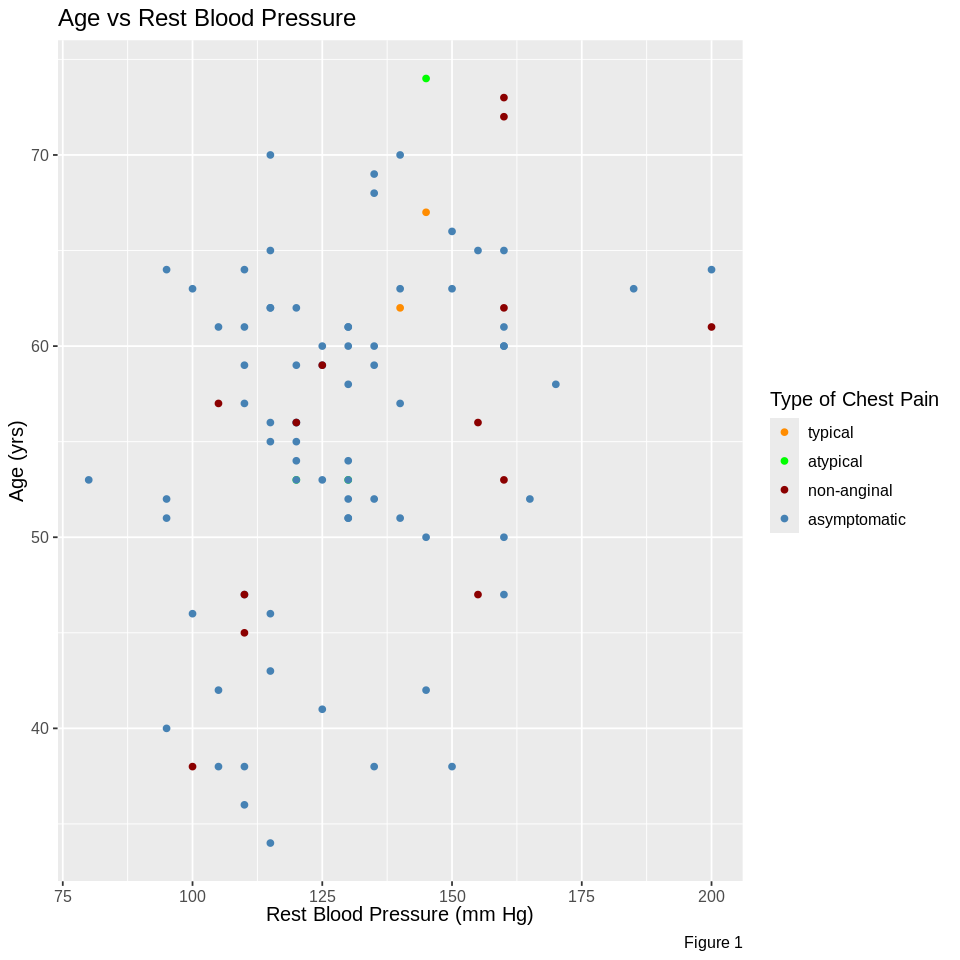

In [5]:
options(repr.plot.height = 8, repr.plot.width = 8)

# create scatter plot of heart disease training set.
heart_disease_plot <- heart_train |>
  ggplot(aes(x = blood_pressure_mm_Hg, y = age, color=chest_pain_ctg)) +
  geom_point() +
  labs(color = "Type of Chest Pain",  x="Rest Blood Pressure (mm Hg)", y="Age (yrs)", 
       caption = "Figure 1") +
  scale_color_manual(values = c("darkorange", "green", "darkred", "steelblue")) +
  theme(text = element_text(size = 12)) +
  ggtitle("Age vs Rest Blood Pressure")


heart_disease_plot

##### Figure 1: Heart Training Dataset colour-coded by Chest Pain Type

In [6]:
pain_proportions <- heart_train |>
                      group_by(chest_pain_ctg) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(heart_train))
pain_proportions

chest_pain_ctg,n,percent
<fct>,<int>,<dbl>
typical,2,2.222222
atypical,3,3.333333
non-anginal,13,14.444444
asymptomatic,72,80.000000


##### Table 3: Percentage of each chest pain type in heart_train dataset.

In [7]:

# show the accuracy of our prelimiary classifier 
#   after cross validation taking in numbers of neighbours from 2 to 6.

# Create recipe
heart_recipe <- recipe(chest_pain_ctg ~ ., data = heart_train) |>
  step_scale(all_numeric_predictors()) |>
  step_center(all_numeric_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# cross-validation for best number of neighbours
heart_vfold <- vfold_cv(heart_train, v = 5, strata = chest_pain_ctg)
k_vals <- tibble(neighbors = seq(from = 2, to = 6, by = 1))

# collect metrics for each number of neighbours
knn_results <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heart_vfold, grid = k_vals) |>
  collect_metrics()

# get their accuracies
accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies

→ A | warning: No observations were detected in `truth` for level(s): 'typical', 'atypical'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

→ B | warning: No observations were detected in `truth` for level(s): 'atypical'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1
→ C | warning: No observations were detected in `truth` for level(s): 'typical'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1
There were issues with some computations   A: x1   B: x1   C: x1

There were issues with some computations   A: x2   B: x1   C: x2





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.6754730,5,0.05496034,Preprocessor1_Model1
3,accuracy,multiclass,0.8015480,5,0.03424546,Preprocessor1_Model2
4,accuracy,multiclass,0.7687994,5,0.03615984,Preprocessor1_Model3
5,accuracy,multiclass,0.8003784,5,0.01175263,Preprocessor1_Model4
6,accuracy,multiclass,0.8003784,5,0.01175263,Preprocessor1_Model5


##### Table 4: Cross-validation accuracies of each # of Neighbours

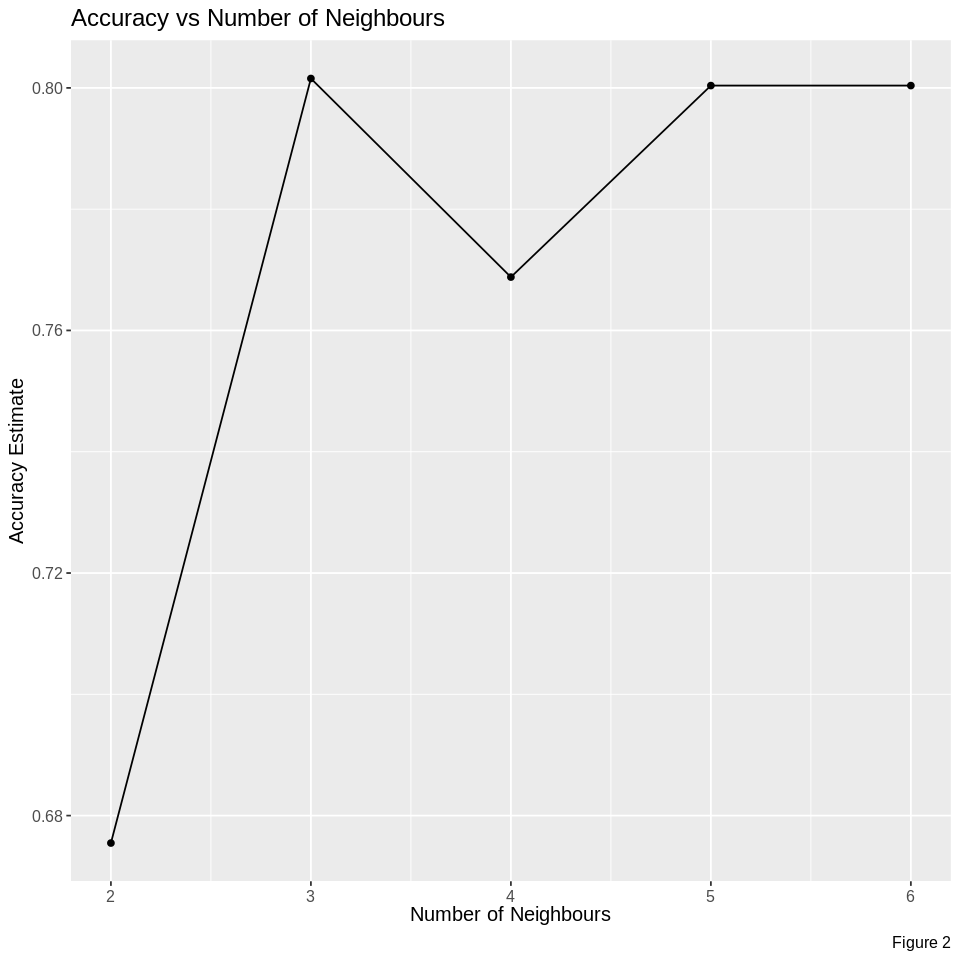

In [8]:
# Let's create a plot that compares the accuracies of the model when choosing different numbers of neighbours
neighbours_plot <- accuracies |> ggplot(aes(x=neighbors, y=mean)) + 
                                    geom_point() + geom_line() + 
                                    labs(x="Number of Neighbours", y = "Accuracy Estimate", caption="Figure 2") +
                                    ggtitle("Accuracy vs Number of Neighbours") +
                                    theme(text = element_text(size = 12))
neighbours_plot

##### Figure 2: Accuracy vs Number of Neighbours for cross-validation results

In [9]:
# get the # of neighbours with the best performance
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 3

In [10]:
# Let's use the best # of neighbours we found to build our new classifier

best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

best_fit <- workflow() |>
                add_model(best_spec) |>
                add_recipe(heart_recipe) |>
                fit(data=heart_train)

In [11]:
# Let's evaluate the performance of our newly-constructed classifier!

# make predictions and bind results to heart_test
heart_test_predictions <- predict(best_fit, heart_test) |>
  bind_cols(heart_test)

# get the model's accuracy
heart_test_predictions |>
  metrics(truth = chest_pain_ctg, estimate = .pred_class) |>
  filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7741935


##### Table 5: Accuracy of classifier with the best # of neighbours

### 77.4% accuracy for predicting the type of chest pain that patients are experiencing from their blood pressure and age.

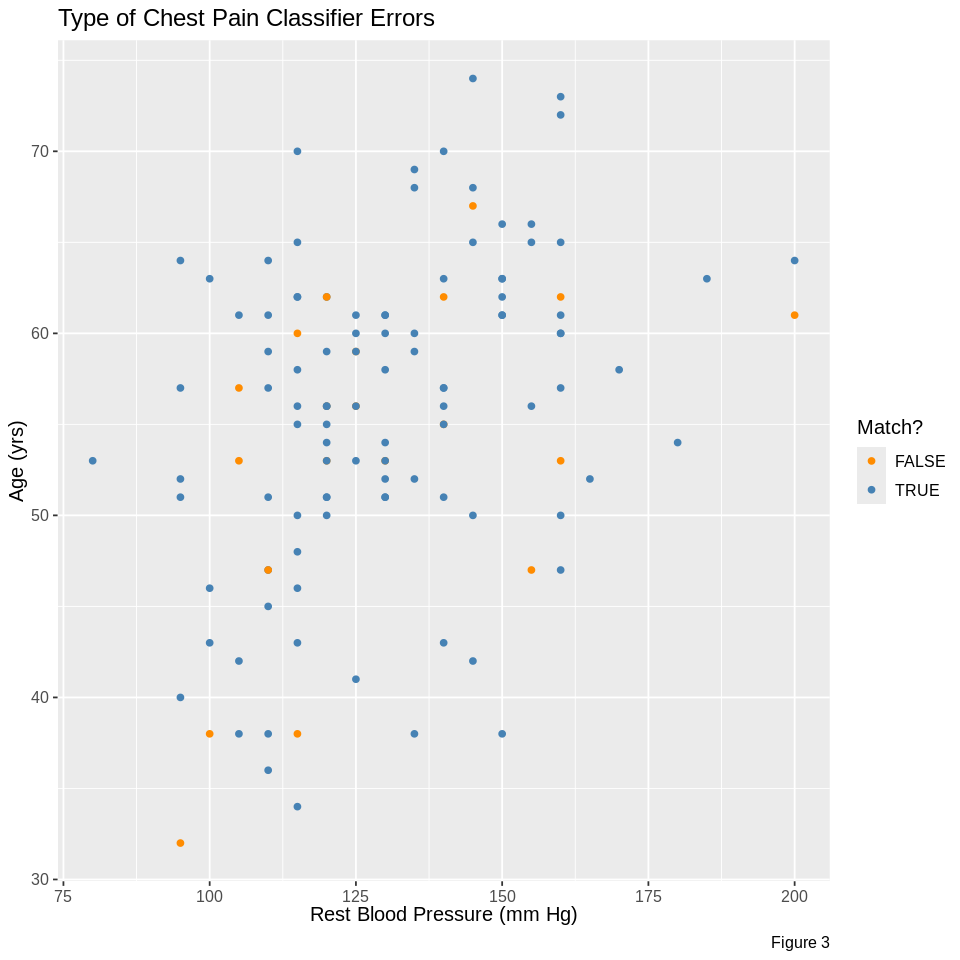

In [12]:
# NEXT STEP, we use our classifier to classify the whole dataset

heart_all_predicted <- predict(best_fit, heart_data) |>
    bind_cols(heart_data)

heart_all_predicted_with_match <- heart_all_predicted |> mutate(match=(.pred_class==chest_pain_ctg))

heart_match_plot <- heart_all_predicted_with_match |>
  ggplot(aes(x = blood_pressure_mm_Hg, y = age, color=match)) +
  geom_point() +
  labs(color = "Match?",  x="Rest Blood Pressure (mm Hg)", y="Age (yrs)", 
       caption = "Figure 3") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12)) +
  ggtitle("Type of Chest Pain Classifier Errors")


heart_match_plot

In [16]:
# confusion matrix for heart_all_predicted

confusion <- heart_all_predicted |> conf_mat(truth=chest_pain_ctg, estimate=.pred_class)

confusion

              Truth
Prediction     typical atypical non-anginal asymptomatic
  typical            0        0           0            0
  atypical           0        1           0            0
  non-anginal        0        0           5            1
  asymptomatic       4        3          12           95